# Pump it Up: Data Mining the Water Table

By: [Ville Heilala](https://heila.la), 2017

Datasource: http://taarifa.org/, http://maji.go.tz/, https://www.drivendata.org

Goal is to predict the operating condition of a waterpoint for each record in the dataset.

## Model the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Pandas version 0.19.2
Matplotlib version 2.0.0


In [2]:
######################
# Read data
##################################################################

train_values = pd.read_csv("/train_values_processed.csv")
test_values = pd.read_csv("/test_values_processed.csv")

## Remove low feature importances one by one

In [14]:
%%capture --no-stdout
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
import csv
import os.path

######################
# Select features
##################################################################

exclude = ("id", "test", "train", "status_group", "num_private", "scheme_name",
           'waterpoint_type_group',
           'quality_group',
           'payment_type',
           'extraction_type_group',
           'extraction_type_class',
           'management_group',
           'source_type',
           'source_class')

error_score = OrderedDict()

while True and not os.path.exists("feature_selection.csv"): 
    # Select all features except which start with a string in exclude
    features = [col for col in list(train_values) if not col.startswith(exclude)]

    ######################
    # Train model
    ##################################################################

    # Build a forest of trees from the training set
    clf = RandomForestClassifier(n_estimators=50, 
                                 min_samples_leaf=2, 
                                 max_features=0.20, 
                                 oob_score=True, 
                                 random_state=20).fit(train_values[features],
                                                      train_values["status_group"])

    ######################
    # Evaluate model
    ##################################################################
    
    oob_score = round(1 - clf.oob_score_, 4)

    print("OOB Error Score: " + str(oob_score))
    
    # Sorted feature importance
    fi = sorted(list(zip(train_values[features], clf.feature_importances_)), key=lambda x: str(x[1]), reverse=True)
    last_fi = [fi[0] for fi in fi[-1:]]
    exclude = exclude + tuple(last_fi)
    
    print(last_fi)
    
    error_score[last_fi[0]] = oob_score

    with open("feature_selection.csv", "w") as csv_file:
        writer = csv.writer(csv_file)
        for key, value in error_score.items():
           writer.writerow([key, value])
    csv_file.close()
    
    if len(fi) < 400:
        break

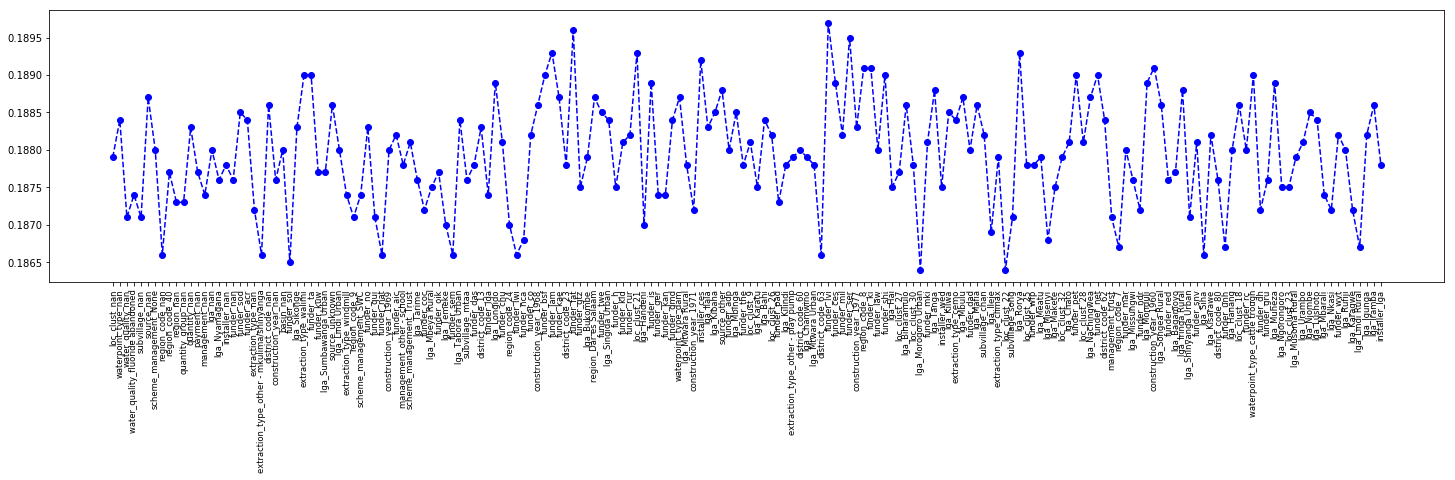

In [13]:
feature_selection = pd.read_csv("feature_selection.csv", header=None)

names = feature_selection[0]
values = feature_selection[1]

plt.figure(figsize=(25,5))
plt.plot(range(len(values)), values, "bo--")
plt.xticks(range(len(values)), names, rotation=90, size="small")
plt.show();

## Principal Component Analysis (PCA)

In [7]:
from sklearn.decomposition import PCA

features = [col for col in list(train_values) if not col.startswith(exclude)]

ipca = PCA(n_components=300, random_state=20)
ipca.fit(train_values[features])
X = ipca.transform(train_values[features])
X.shape

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(59400, 300)

In [8]:
clf = RandomForestClassifier(n_estimators=50, 
                             min_samples_leaf=2, 
                             max_features=0.20, 
                             oob_score=True, 
                             random_state=20).fit(X,
                                                  train_values["status_group"])
oob_score = round(1 - clf.oob_score_, 4)
oob_score

0.2094